## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch

In [2]:
# https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=status.csv
dataset_station_statut = pd.read_csv("../../../../Bike_Data/status.csv")
dataset_station = pd.read_csv("../../../../Bike_Data/station.csv")

## Class TimeSeriesDataset

In [3]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride, target_size=1, drop=None):
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.target_size = target_size
        self.drop = drop

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size:idx+self.window_size+self.target_size]
        if self.drop is not None:
            target = np.delete(target, self.drop, axis=1)
        return inputs, target

## Class GRU

In [4]:
class GRUNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

## Station statut dataset

## Station dataset

In [5]:
dataset_station.head(3)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013


In [6]:
dataset_station.shape

(70, 7)

## Merge dataset Station statut and Station

In [7]:
dataset = pd.merge(dataset_station, dataset_station_statut, left_on='id', right_on='station_id')

In [8]:
dataset.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:06:01
1,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:07:01
2,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:08:01


In [9]:
dataset.shape

(71984434, 11)

### See the mean variation for differents interval of time

In [10]:
dataset_station_statut_drop = dataset_station_statut.drop(["docks_available"], axis=1)
dataset_station_statut_drop['time'] = pd.to_datetime(dataset_station_statut_drop['time'], format="mixed")
pivoted_dataset_station_statut_drop = dataset_station_statut_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [11]:
import pandas as pd

# assuming your dataframe is named df and has a datetime index
intervals = ['5min', '10min', '15min', '30min', '60min']
for interval in intervals:
    resampled = pivoted_dataset_station_statut_drop.resample(interval).var().mean().sort_values(ascending=False)
    print(f'Mean Variance for {interval} interval:')
    print(resampled)

Mean Variance for 5min interval:
station_id
70    0.227252
69    0.152443
50    0.144004
61    0.110123
60    0.104654
        ...   
33    0.006550
8     0.006083
23    0.005957
38    0.005068
5     0.004799
Length: 70, dtype: float64
Mean Variance for 10min interval:
station_id
70    0.500550
69    0.343188
50    0.317341
61    0.233667
60    0.210250
        ...   
8     0.011556
33    0.010267
5     0.008726
23    0.008316
38    0.007830
Length: 70, dtype: float64
Mean Variance for 15min interval:
station_id
70    0.783799
69    0.557002
50    0.492731
61    0.346430
65    0.325293
        ...   
8     0.016246
33    0.013776
5     0.012483
38    0.010602
23    0.010149
Length: 70, dtype: float64
Mean Variance for 30min interval:
station_id
70    1.463287
69    1.152336
50    1.010326
61    0.691692
65    0.667708
        ...   
5     0.024140
83    0.024065
33    0.023480
38    0.017727
23    0.014105
Length: 70, dtype: float64
Mean Variance for 60min interval:
station_id
70    2.

# 1/ (Mulivariate) Selection of n station to make prediction

### All id station available

In [12]:
print(dataset['id'].unique())
print(len(dataset['id'].unique()))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 41 42 45 46 47 48 49 50 51 39 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84]
70


#### Select stations

In [13]:
id_station = [42, 70, 60, 61, 45, 77, 69]

In [14]:
dataset_station_id = dataset.loc[dataset['id'].isin(id_station)]

In [15]:
dock_count = dataset_station_id['dock_count'].unique()
print(dock_count)

[15 27 23 19]


In [16]:
dataset_station_id.shape

(7329983, 11)

In [17]:
dataset_station_id.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
34204912,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:06:01
34204913,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:07:01
34204914,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:08:01


In [18]:
dataset_station_id.tail(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
68740952,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013,77,13,14,2015-08-31 23:57:02
68740953,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013,77,13,14,2015-08-31 23:58:02
68740954,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013,77,13,14,2015-08-31 23:59:02


### Drop columns

In [19]:
dataset_station_id_drop = dataset_station_id.drop(["name", 'lat', 'long', 'id', 'city', 'installation_date', "docks_available", "dock_count"], axis=1)

In [20]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013/08/29 12:06:01


### Check presence of null and NaN values

In [21]:
dataset_station_id_drop.isna().sum()

station_id         0
bikes_available    0
time               0
dtype: int64

In [22]:
dataset_station_id_drop[dataset_station_id_drop.isna().any(axis=1)]

,station_id,bikes_available,time


In [23]:
dataset_station_id_drop.dtypes

station_id          int64
bikes_available     int64
time               object
dtype: object

### Conversion column time to datetime

In [24]:
dataset_station_id_drop['time'] = pd.to_datetime(dataset_station_id_drop['time'], format="mixed")

In [25]:
dataset_station_id_drop.dtypes

station_id                  int64
bikes_available             int64
time               datetime64[ns]
dtype: object

In [26]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013-08-29 12:06:01


In [27]:
dataset_station_id_drop.tail(1)

,station_id,bikes_available,time
68740954,77,13,2015-08-31 23:59:02


### Train

In [28]:
def plot_loss_valid(valid_losses):
    plt.plot(valid_losses, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()

In [29]:
# Train your model and evaluate on the validation set
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    num_epochs = num_epochs
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        val_loss = 0.0
    
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            val_loss += loss.item()
        
        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_LSTM.pth')
    
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    plot_loss_valid(valid_losses)
    
    

### Test

In [30]:
def test_model(best_model, test_loader, criterion):
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.squeeze(dim=(1)))
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.squeeze(dim=(1)).cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return (predictions, actuals)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Print Global Metrics 

In [32]:
def result_prediction(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        y_pred = predictions[:,i]
        y_true = actuals[:,i]

        signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)*100
        if (mape > 1 or mape < 0):
            mape = "ERROR"
        smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
        maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

        # Ajouter une ligne au tableau avec le nom du mois et les metrics
        data.append(["Global", signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Global', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Global', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each month

In [33]:
def result_prediction_by_month(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='M'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_month.append((name.strftime('%B'), indices))

        for name, indice in indices_by_month:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Month', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Month', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each week

In [34]:
def result_prediction_by_week(predictions, actuals):
    indices_by_week = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='W'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_week.append((name.strftime('%W'), indices))

        for name, indice in indices_by_week:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                    mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Week', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Week', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each day

In [35]:
def result_prediction_by_day(predictions, actuals):
    indices_by_day = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='D'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_day.append((name.timetuple().tm_yday, indices))

        for name, indice in indices_by_day:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each hour

In [36]:
def result_prediction_by_hour(predictions, actuals):
    indices_by_hour = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='H'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_hour.append((name, indices))

        for name, indice in indices_by_hour:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]
            if len(y_pred) != 0 and len(y_true != 0) :
                signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = mean_absolute_percentage_error(y_true, y_pred)*100
                if (mape > 1 or mape < 0):
                    mape = "ERROR"
                smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
                maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

                # Ajouter une ligne au tableau avec le nom du mois et les metrics
                data.append([f'{name.timetuple().tm_yday} / {name.hour}', signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day / Hour', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day / Hour', inplace=True)
    # Retourner le DataFrame
    return df

## Trying to forecast the availability of bikes 

In [37]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
pivoted_df_station_id = dataset_station_id_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [39]:
pivoted_df_station_id.head(10)

station_id,42,45,60,61,69,70,77
time,,,,,,,
2013-08-29 12:06:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:07:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:08:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:09:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:10:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:11:01,7.0,11.0,8.0,11.0,4.0,0.0,11.0
2013-08-29 12:12:01,7.0,11.0,8.0,11.0,4.0,0.0,11.0
2013-08-29 12:13:01,7.0,11.0,8.0,11.0,4.0,0.0,10.0
2013-08-29 12:15:01,7.0,11.0,8.0,11.0,4.0,0.0,10.0


### First Experimentation

#### Use 15 min to predict the 5th next min

In [40]:
df_weekday_hour = pivoted_df_station_id.groupby(pd.Grouper(freq='5min'), dropna=True).mean()

In [41]:
# window_size = "10min"
# df_weekday_hour = group.rolling(window_size).mean()

In [42]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])    

752

In [43]:
df_weekday_hour = df_weekday_hour.dropna()

In [44]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

0

In [45]:
df_weekday_hour_prep = df_weekday_hour.copy()

In [46]:
df_weekday_hour_prep.head(4)

station_id,42,45,60,61,69,70,77
time,,,,,,,
2013-08-29 12:05:00,7.0,11.0,8.0,11.0,4.0,0.00,14.0
2013-08-29 12:10:00,7.0,11.0,8.0,11.0,4.0,0.00,11.5
2013-08-29 12:15:00,7.0,11.5,8.5,11.0,4.0,0.25,10.0
2013-08-29 12:20:00,7.0,12.0,9.5,11.0,4.0,1.00,10.5


In [47]:
df_weekday_hour_prep[df_weekday_hour_prep.isna().any(axis=1)]

station_id,42,45,60,61,69,70,77
time,,,,,,,


In [48]:
train_data = df_weekday_hour_prep[:'2014-11-01 12:00:00']
valid_data = df_weekday_hour_prep['2014-11-01 12:00:00':'2015-01-01 12:00:00']
test_data = df_weekday_hour_prep['2015-01-01 12:00:00':'2015-08-31 13:00:00']

##### f(a(t), b(t), c(t)) = a(t+1), b(t+1) + c(t+1)

In [49]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = len(id_station)
output_LSTM = len(id_station)

# Instantiate your LSTM model and define the loss function and optimizer
model = GRUNet(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Training Loss: 84402.4232, Validation Loss: 17.5170
Epoch 2/50, Training Loss: 52366.7554, Validation Loss: 10.2172
Epoch 3/50, Training Loss: 26759.2849, Validation Loss: 4.7986
Epoch 4/50, Training Loss: 12639.4325, Validation Loss: 2.9007
Epoch 5/50, Training Loss: 8558.7709, Validation Loss: 1.8838
Epoch 6/50, Training Loss: 5340.2083, Validation Loss: 1.2418
Epoch 7/50, Training Loss: 3692.0936, Validation Loss: 0.9841
Epoch 8/50, Training Loss: 3226.7848, Validation Loss: 0.8499
Epoch 9/50, Training Loss: 2999.8551, Validation Loss: 0.7835
Epoch 10/50, Training Loss: 2874.9744, Validation Loss: 0.7470
Epoch 11/50, Training Loss: 2763.8490, Validation Loss: 0.7161
Epoch 12/50, Training Loss: 2715.4294, Validation Loss: 0.7334
Epoch 13/50, Training Loss: 2588.7602, Validation Loss: 0.7551
Epoch 14/50, Training Loss: 2520.2667, Validation Loss: 0.7213
Epoch 15/50, Training Loss: 2439.8399, Validation Loss: 0.7058
Epoch 16/50, Training Loss: 2422.8273, Validation Loss: 0.

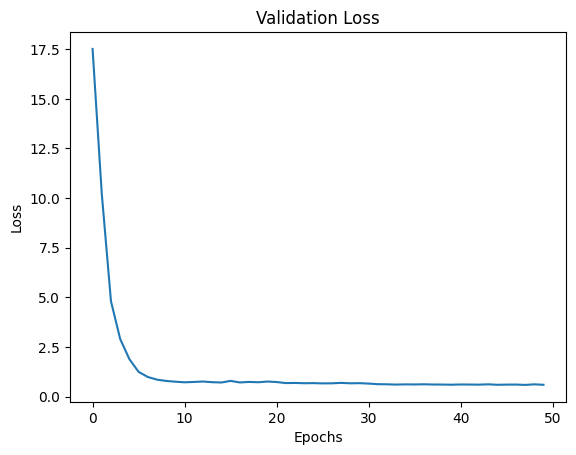

In [51]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 50)

In [52]:
best_model =  GRUNet(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_n, actuals_n_to_n = test_model(best_model, test_loader, criterion)

Test Loss: 0.6716


In [53]:
results_global_n_to_n =  result_prediction(predictions_n_to_n, actuals_n_to_n)
results_global_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,+,0.348641,0.536734,ERROR,8.867491,8.637778


In [54]:
results_month_n_to_n = result_prediction_by_month(predictions_n_to_n, actuals_n_to_n)
results_month_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,+,0.338509,0.505930,ERROR,7.337498,7.339627
February,+,0.305439,0.476348,ERROR,8.209029,7.991779
March,+,0.387194,0.567928,ERROR,9.761195,9.576938
April,+,0.335155,0.517710,ERROR,9.256549,8.896064
May,+,0.348419,0.528523,ERROR,10.535003,10.501319
June,+,0.350058,0.577773,ERROR,9.569501,9.067225
July,+,0.368544,0.556749,ERROR,7.342373,7.112585
August,+,0.351209,0.550455,ERROR,8.876367,8.552851


In [55]:
results_week_n_to_n = result_prediction_by_week(predictions_n_to_n, actuals_n_to_n)
results_week_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,+,0.243673,0.317266,ERROR,3.359657,3.429864
01,+,0.346050,0.491068,ERROR,8.570244,8.604933
02,+,0.356024,0.536658,ERROR,7.786061,7.659700
03,+,0.327151,0.523070,ERROR,6.331962,6.499475
04,+,0.343078,0.518860,ERROR,7.861076,7.756371
05,+,0.289537,0.464728,ERROR,6.774575,6.837160
06,+,0.329101,0.529949,ERROR,9.054446,8.680949
07,+,0.347107,0.484186,ERROR,8.543884,8.300411
08,+,0.258681,0.419341,ERROR,8.632669,8.318114


In [56]:
results_day_n_to_n = result_prediction_by_day(predictions_n_to_n, actuals_n_to_n)
results_day_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
1,+,0.284213,0.322628,ERROR,4.571873,4.654043
2,+,0.193010,0.257138,ERROR,2.340341,2.351125
3,+,0.278798,0.385650,ERROR,3.430588,3.530074
4,+,0.238940,0.292254,ERROR,3.701935,3.796304
5,+,0.504686,0.681070,ERROR,13.874130,14.127783
...,...,...,...,...,...,...
239,+,0.386545,0.526715,ERROR,7.433125,7.654943
240,+,0.413872,0.612875,ERROR,8.670328,8.595582
241,+,0.263971,0.342072,ERROR,3.324307,3.352277


In [57]:
results_hour_n_to_n = result_prediction_by_hour(predictions_n_to_n, actuals_n_to_n)
results_hour_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
1 / 12,+,0.176533,0.227663,ERROR,2.678980,2.719833
1 / 13,+,0.252288,0.261804,ERROR,6.100406,6.297002
1 / 14,+,0.502887,0.575492,ERROR,10.658695,10.677798
1 / 15,+,0.344687,0.441315,ERROR,5.459710,5.683741
1 / 16,+,0.222446,0.263844,ERROR,3.187588,3.174685
...,...,...,...,...,...,...
243 / 9,-,0.830396,1.167223,ERROR,9.385854,8.736988
243 / 10,+,0.557948,0.816721,ERROR,4.448810,4.596250
243 / 11,+,0.585459,0.637404,ERROR,6.445834,6.685919


In [58]:
results_global_n_to_n.to_csv(f"results_global_n_to_n_station_{len(id_station)}.csv")
results_month_n_to_n.to_csv(f"results_month_n_to_n_station_{len(id_station)}.csv")
results_week_n_to_n.to_csv(f"results_week_n_to_n_station_{len(id_station)}.csv")
results_day_n_to_n.to_csv(f"results_day_n_to_n_station_{len(id_station)}.csv")
results_hour_n_to_n.to_csv(f"results_hour_n_to_n_station_{len(id_station)}.csv")

##### f(a(t), b(t), c(t)) = a(t+1)

In [59]:
df_weekday_hour_prep.head(3)

station_id,42,45,60,61,69,70,77
time,,,,,,,
2013-08-29 12:05:00,7.0,11.0,8.0,11.0,4.0,0.00,14.0
2013-08-29 12:10:00,7.0,11.0,8.0,11.0,4.0,0.00,11.5
2013-08-29 12:15:00,7.0,11.5,8.5,11.0,4.0,0.25,10.0


In [60]:
# Define the sliding window size and stride
window_size = 3
stride = 1
drop_columns = [i for i in range(1, len(id_station))]

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride, drop=drop_columns)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride, drop=drop_columns)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride, drop=drop_columns)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = len(id_station)
output_LSTM = 1

# Instantiate your LSTM model and define the loss function and optimizer
model = GRUNet(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/100, Training Loss: 19501.9042, Validation Loss: 2.3681
Epoch 2/100, Training Loss: 1733.7838, Validation Loss: 0.2557
Epoch 3/100, Training Loss: 1066.0640, Validation Loss: 0.2282
Epoch 4/100, Training Loss: 908.9283, Validation Loss: 0.1773
Epoch 5/100, Training Loss: 822.7875, Validation Loss: 0.1566
Epoch 6/100, Training Loss: 792.7449, Validation Loss: 0.1725
Epoch 7/100, Training Loss: 724.8613, Validation Loss: 0.1584
Epoch 8/100, Training Loss: 691.0132, Validation Loss: 0.1728
Epoch 9/100, Training Loss: 655.0851, Validation Loss: 0.1563
Epoch 10/100, Training Loss: 650.1134, Validation Loss: 0.1584
Epoch 11/100, Training Loss: 630.4365, Validation Loss: 0.1879
Epoch 12/100, Training Loss: 629.4322, Validation Loss: 0.1704
Epoch 13/100, Training Loss: 623.7235, Validation Loss: 0.1885
Epoch 14/100, Training Loss: 623.4370, Validation Loss: 0.2041
Epoch 15/100, Training Loss: 634.0368, Validation Loss: 0.1685
Epoch 16/100, Training Loss: 623.8656, Validation Loss: 0.18

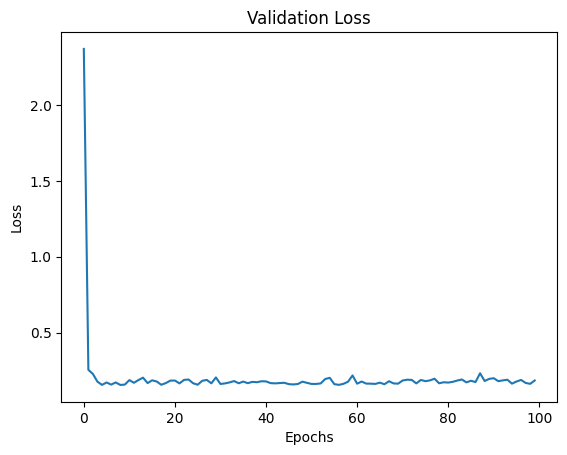

In [62]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 100)

In [63]:
best_model =  GRUNet(input_size=input_LSTM, hidden_size=32, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_1, actuals_n_to_1 = test_model(best_model, test_loader, criterion)

Test Loss: 0.1899


In [64]:
result_global_n_to_1 = result_prediction(predictions_n_to_1, actuals_n_to_1)
result_global_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,+,0.213739,0.435588,ERROR,5.865445,5.36826


In [65]:
results_month_n_to_1 = result_prediction_by_month(predictions_n_to_1, actuals_n_to_1)
results_month_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,+,0.180945,0.385785,ERROR,4.309541,4.093704
February,+,0.168665,0.371700,ERROR,4.918980,4.562990
March,+,0.231827,0.450435,ERROR,6.168414,5.726302
April,+,0.223645,0.437135,ERROR,6.759210,6.135795
May,-,0.192384,0.406630,ERROR,6.115889,5.538121
June,+,0.229961,0.485337,ERROR,6.980517,6.272648
July,-,0.252950,0.479648,ERROR,5.317614,4.907195
August,-,0.226002,0.449912,ERROR,6.316304,5.676049


In [66]:
results_week_n_to_1 = result_prediction_by_week(predictions_n_to_1, actuals_n_to_1)
results_week_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,+,0.100563,0.181989,ERROR,1.403929,1.408594
01,-,0.185678,0.331710,ERROR,5.529719,5.143265
02,+,0.185672,0.399221,ERROR,4.563378,4.255359
03,+,0.201918,0.439830,ERROR,3.603924,3.590664
04,+,0.175719,0.416905,ERROR,4.528537,4.292582
05,-,0.168090,0.367757,ERROR,3.849232,3.742740
06,+,0.200712,0.435833,ERROR,5.780164,5.289842
07,+,0.171947,0.351784,ERROR,4.990975,4.660426
08,+,0.133656,0.319764,ERROR,5.138023,4.641144


In [67]:
results_day_n_to_1 = result_prediction_by_day(predictions_n_to_1, actuals_n_to_1)
results_day_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
1,+,0.121884,0.219505,ERROR,1.895573,1.868861
2,-,0.104260,0.181736,ERROR,1.212133,1.208712
3,+,0.089538,0.181064,ERROR,1.201582,1.215677
4,+,0.097230,0.161296,ERROR,1.552251,1.571259
5,+,0.271733,0.447354,ERROR,8.877247,8.345760
...,...,...,...,...,...,...
239,-,0.300312,0.498887,ERROR,4.688341,4.675582
240,-,0.251148,0.479179,ERROR,5.444359,5.253523
241,+,0.104957,0.223284,ERROR,1.489159,1.498070


In [68]:
results_hour_n_to_1 = result_prediction_by_hour(predictions_n_to_1, actuals_n_to_1)
results_hour_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
1 / 12,-,0.124323,0.207676,ERROR,1.406888,1.394005
1 / 13,+,0.057510,0.064484,ERROR,1.424961,1.437563
1 / 14,-,0.291009,0.528805,ERROR,5.494895,5.057898
1 / 15,+,0.188971,0.335859,ERROR,2.982577,3.103415
1 / 16,-,0.150972,0.277424,ERROR,2.216732,2.150893
...,...,...,...,...,...,...
243 / 9,-,0.928262,1.141366,ERROR,10.112232,9.467910
243 / 10,-,0.974161,1.020274,ERROR,7.613361,7.517964
243 / 11,+,0.209342,0.339707,ERROR,2.348138,2.417744


In [69]:
result_global_n_to_1.to_csv(f"results_global_n_to_1_station_{len(id_station)}.csv")
results_month_n_to_1.to_csv(f"results_month_n_to_1_station_{len(id_station)}.csv")
results_week_n_to_1.to_csv(f"results_week_n_to_1_station_{len(id_station)}.csv")
results_day_n_to_1.to_csv(f"results_day_n_to_1_station_{len(id_station)}.csv")
results_hour_n_to_1.to_csv(f"results_hour_n_to_1_station_{len(id_station)}.csv")